<a href="https://colab.research.google.com/github/rodrigoulart/projeto-site/blob/main/projeto_de_transfer_learning_em_python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Instalação e importação
!pip install tensorflow --quiet

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import zipfile
import matplotlib.pyplot as plt


In [13]:
# Baixar e descompactar dataset
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
dataset_path = "/content/kagglecatsanddogs_5340.zip"

# Baixar o arquivo
os.system(f"curl -o {dataset_path} {url}")

# Descompactar o arquivo
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Diretório do dataset
data_dir = "/content/PetImages"
os.listdir(data_dir)


['Cat', 'Dog']

In [14]:
# Bloco 3 – Preparar geradores de treino e validação com filtro de imagens corrompidas
from PIL import Image
import shutil

IMG_SIZE = 224
BATCH_SIZE = 32

# Função para verificar imagens válidas
def filter_corrupted_images(folder):
    valid_files = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path)
            img.verify()  # verifica se a imagem está OK
            valid_files.append(file_path)
        except:
            print(f"Imagem corrompida removida: {file_path}")
    return valid_files

# Filtrar imagens corrompidas
cat_files = filter_corrupted_images(os.path.join(data_dir, "Cat"))
dog_files = filter_corrupted_images(os.path.join(data_dir, "Dog"))

# Criar pastas temporárias para imagens válidas
clean_dir = "/content/cleaned_pet_images"
os.makedirs(os.path.join(clean_dir, "Cat"), exist_ok=True)
os.makedirs(os.path.join(clean_dir, "Dog"), exist_ok=True)

# Copiar imagens válidas para as pastas limpas
for f in cat_files:
    shutil.copy(f, os.path.join(clean_dir, "Cat"))
for f in dog_files:
    shutil.copy(f, os.path.join(clean_dir, "Dog"))

# Geradores usando pastas limpas
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    clean_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    clean_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

# Limitar número de batches para acelerar treinamento
steps_per_epoch = 100
validation_steps = 50


Imagem corrompida removida: /content/PetImages/Cat/666.jpg
Imagem corrompida removida: /content/PetImages/Cat/Thumbs.db
Imagem corrompida removida: /content/PetImages/Dog/11702.jpg
Imagem corrompida removida: /content/PetImages/Dog/Thumbs.db
Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [15]:
# Criar modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
# Treinar camadas finais
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8551 - loss: 0.3758 - val_accuracy: 0.9800 - val_loss: 0.0757
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9610 - loss: 0.1039 - val_accuracy: 0.9806 - val_loss: 0.0593
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9657 - loss: 0.0890 - val_accuracy: 0.9794 - val_loss: 0.0513


In [17]:
# Fine-Tuning parcial
base_model.trainable = True

# Congelar todas as camadas menos as últimas 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.8359 - loss: 0.3675 - val_accuracy: 0.9819 - val_loss: 0.0532
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.9393 - loss: 0.1404 - val_accuracy: 0.9806 - val_loss: 0.0509
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9549 - loss: 0.1036 - val_accuracy: 0.9850 - val_loss: 0.0411


In [18]:
# Avaliar modelo
loss, acc = model.evaluate(validation_generator, steps=validation_steps)
print(f'Val Loss: {loss:.4f}, Val Accuracy: {acc:.4f}')


50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9825 - loss: 0.0484
Val Loss: 0.0436, Val Accuracy: 0.9844


In [19]:
# Salvar modelo
model.save('cats_dogs_transfer_learning_finetune.h5')


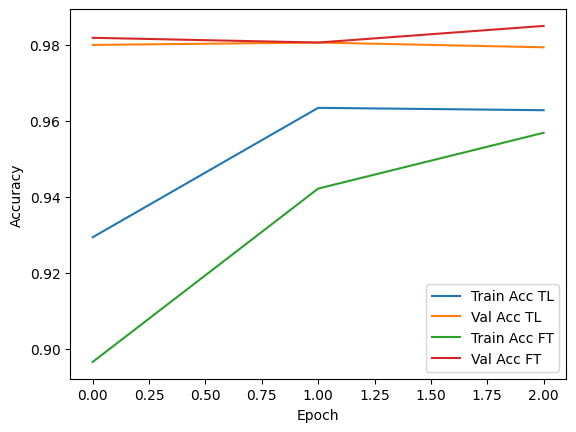

In [20]:
# Plotar histórico de treino
plt.plot(history.history['accuracy'], label='Train Acc TL')
plt.plot(history.history['val_accuracy'], label='Val Acc TL')

plt.plot(history_finetune.history['accuracy'], label='Train Acc FT')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc FT')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
